In [184]:
import mygene
import numpy as np
import pandas as pd
import os
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [183]:
nean_data_dir = "./neanderthal_introgressed/"
allen_data_dir = "./alleninf/alleninf/data/"
donor_data_dir = "./donor_data/"
MNI_brain = "/usr/share/fsl/5.0/data/standard/MNI152_T1_1mm_brain.nii.gz"

CLOBBER = False
MNI_corr = pd.read_csv(os.path.join(allen_data_dir,"corrected_mni_coordinates.csv"),header=0,index_col=0)
# see NOTES.txt for a description of contents, note that CIs may need to be incorporated but the "per_genene"
# file gives us a place to start
nn_CB_per_gene = pd.read_csv(os.path.join(nean_data_dir,"ase_cerebellum.per_gene.txt"),sep="\t",header=0)
nn_CB_per_snp  = pd.read_csv(os.path.join(nean_data_dir,"ase_cerebellum.per_snp.txt"),sep="\t",header=0)

out_ensembl2gene = "ase_cerebellum_ensembl2gene.csv"

In [4]:
MNI_corr.head()

,corrected_mni_x,corrected_mni_y,corrected_mni_z
well_id,,,
126439333,-13.467693,2.255686,3.432523
126432538,-53.603259,-8.120055,0.868643
126435762,-16.288739,-34.198856,-19.944686
126439285,-17.820212,3.595613,-32.872868
126435744,-23.726456,-25.139000,-16.692841


In [5]:
nn_CB_per_snp.head()

,chrom,pos,geneid,est.mean,sd.sd,ci0.005,ci0.025,ci0.975,ci0.995,REF,ALT,RSID,ANCESTRAL,GLOBAL_AF,EAS_AF,EUR_AF,est.scaled,est.scaled.polarized
0,1,3551792,ENSG00000116213,-0.117100,0.019119,-0.166485,-0.154656,-0.079607,-0.067841,G,A,rs2296034,G,0.078674,0.1915,0.0388,-0.120094,-0.120094
1,1,10220149,ENSG00000130939,0.559621,0.626792,-0.962172,-0.617283,1.848444,2.294328,T,G,rs77148178,T,0.006190,0.0000,0.0219,1.763459,1.763459
2,1,10221136,ENSG00000130939,-1.386307,0.790525,-3.718340,-3.090941,0.013753,0.390911,G,C,rs114631287,G,0.006190,0.0000,0.0219,-3.652746,-3.652746
3,1,10334544,ENSG00000054523,-0.080021,0.400384,-1.120116,-0.869507,0.702521,0.946659,C,T,rs115415660,C,0.006589,0.0000,0.0229,-0.016892,-0.016892
4,1,10363664,ENSG00000054523,-0.040922,0.043353,-0.153018,-0.126138,0.044048,0.070686,G,T,rs41274458,G,0.006589,0.0000,0.0229,0.091934,0.091934


In [6]:
nn_CB_per_gene.head()

,geneid,est.scaled.polarized.mean
0,ENSG00000000457,0.527106
1,ENSG00000002746,-0.887026
2,ENSG00000003249,-0.594831
3,ENSG00000003987,0.451745
4,ENSG00000004799,0.137427


In [7]:
## extract gene names and additional information about the gene from the ensemble ID
genes = nn_CB_per_gene['geneid'] #these are the ensemble gene ids, called "ensembl.gene" in mygene
fields = "alias,summary,symbol,name,taxid,entrezgene,ensembl.gene"
if not os.path.isfile(out_ensembl2gene) or CLOBBER == True:
    mg = mygene.MyGeneInfo()
    df_genes = mg.querymany(list(genes),species="human",
                            fields=fields,
                            as_dataframe=True,
                            email="christopher.steele@mail.mcgill.ca")
    df_genes.to_csv(out_ensembl2gene)
else:
    df_genes = pd.read_csv(out_ensembl2gene)

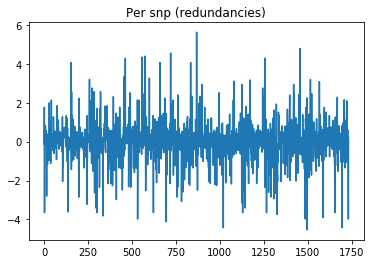

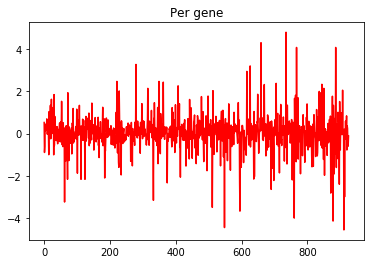

In [8]:
plt.plot(nn_CB_per_snp['est.scaled.polarized'])
plt.title('Per snp (redundancies)')
#plt.bar(np.arange(nn_CB_per_snp.shape[0]),nn_CB_per_snp['est.scaled.polarized'])
plt.figure()
plt.plot(nn_CB_per_gene['est.scaled.polarized.mean'],'r')
plt.title('Per gene')

In [9]:
## merge the df_genes with our neanderthal data
df_gene_nn = pd.merge(df_genes,nn_CB_per_gene,left_on="query",right_on="geneid")


In [111]:
## work with the code that K. Gorgolewski wrote
# reads allen database donor data (whatever is in the dir)
def read_donor_data(data_dir):
    from glob import glob
    donor_ids = [path.split(os.path.sep)[-2] for path in glob(os.path.join(data_dir, "*", "MicroarrayExpression.csv"))]
    print "Data directory contains the following donors: %s" % ", ".join(donor_ids)
    main_df = "empty"
    for donor_id in donor_ids:
        print "Reading data from donor %s"%donor_id
        sample_locations = pd.read_csv(os.path.join(data_dir, donor_id, 'SampleAnnot.csv'))
        df = pd.DataFrame([donor_id] * sample_locations.shape[0], columns=["donor_id"]) #column of donor_id
        df_well_ids = sample_locations[['well_id',"slab_type"]] #keep slab type so that we can filter on it
        df = pd.concat([df,df_well_ids],axis=1,ignore_index=False)
        expression_data = pd.read_csv(os.path.join(data_dir, donor_id, 'MicroarrayExpression.csv'), header=None, index_col=0)
        expression_data.columns = range(expression_data.shape[1])
        df = pd.concat([df, expression_data.T], axis=1, ignore_index=False)
        if isinstance(main_df, str):
            main_df = df
        else:
            main_df = pd.concat([main_df, df], ignore_index=True)
    return main_df #now formatted by row,col sample_well_id,probe_id

In [112]:
#df_donors = read_donor_data(donor_data_dir)


Data directory contains the following donors: H0351.2001
Reading data from donor H0351.2001


In [128]:
#df_donors[df_donors['slab_type']=='CB'].shape

(53, 58695)

Reading donor data was performed on the CIC workstation in the other ipynb file (2017_05_NeanderthalCB_Genes2MNI.v3.ipynb). The data was transferred here, selecting out only the CB slab.

In [130]:
CB_donor_file = "donors_all_slab_type_CB.csv"
df_donor_data_CB = pd.read_csv(os.path.join(donor_data_dir,CB_donor_file),header=0)
print(df_donor_data_CB.shape)
df_donor_data_CB.head()

,Unnamed: 0,donor_id,well_id,slab_type,1058685,1058684,1058683,1058682,1058681,1058680,...,1071202,1071203,1071204,1071205,1071206,1071207,1071208,1071209,1071210,1071211
0,156,H0351.1016,158402984,CB,3.947622,0.674488,0.791284,4.107686,5.491067,8.473847,...,6.454849,7.186370,1.102663,4.426406,10.365387,6.624539,7.147432,1.084218,1.309453,7.024254
1,157,H0351.1016,158402888,CB,3.588285,0.679310,0.777257,4.548565,5.923960,8.472125,...,6.254529,6.877880,3.089069,4.260493,9.958622,6.046748,7.289132,2.561823,1.509929,7.327896
2,158,H0351.1016,158402986,CB,3.075499,1.606844,0.759579,4.360879,5.984050,8.388368,...,5.079211,6.382025,1.780008,4.163607,9.832228,5.686386,7.410866,1.944031,3.481299,7.604971
3,159,H0351.1016,158402970,CB,3.873422,0.674488,0.680751,4.862344,5.935894,8.329800,...,6.528572,7.308408,0.684117,4.254972,9.620506,6.422685,6.755590,2.732050,1.509975,6.286960
4,160,H0351.1016,158402938,CB,3.641216,0.674488,1.476461,4.293067,5.832138,8.195117,...,6.199264,7.327566,2.362821,4.283316,9.693019,6.547512,7.121835,3.215737,1.632292,7.466845


In [135]:
#compress it
df_donor_data_CB.to_hdf(os.path.join(donor_data_dir,CB_donor_file.split(".")[0]+".hdf"),
                        'w',complib="zlib",complevel=6)
(df_donor_data_CB.columns.isin(list('donor_id')))

In [207]:
#identify the genes that overlap between the nn and the donor datasets, include the probe numbers
nn_genes = df_gene_nn.symbol #the raw symbols have extra information in them from the mygene data, strip it
gene2probe = df_probes.gene_symbol 
overlap = gene2probe[gene2probe.isin(nn_genes)] #THIS IS NOT CORRECT XXX

In [208]:
#overlap.to_csv('shit.csv')

probe_id
1058512       CCNT1
1058511       CCNT1
1058510       CCNT1
1058176        CKS2
1058175        CKS2
1058168       CLCN2
1058167       CLCN2
1058163       CLCN6
1058162       CLCN6
1058161       CLCN6
1058160       CLCN6
1058159       CLCN6
1058158       CLCN6
1058104       CNTN1
1058103       CNTN1
1058020       COX10
1058019       COX10
1058012          CP
1058011          CP
1057815       CYB5A
1057814       CYB5A
1058257        CHML
1058256        CHML
1057443       DUSP6
1057442       DUSP6
1057441       DUSP6
1057889       CSRP1
1057888       CSRP1
1057887       CSRP2
1057886       CSRP2
             ...   
1066628        CHD6
1066803        WWC1
1067416      CTNNA3
1067463       CNOT7
1067477      MAP3K9
1067793        UBA2
1067847        NBEA
1067873       RPL21
1067874       RPL21
1067875       RPL21
1068028        TSC1
1068103         GK5
1068273       DNAH2
1068278      RSBN1L
1068319     ST8SIA1
1068344     ZNF385D
1068615       PHTF2
1068870        QDPR
1069603    

In [182]:
nn_genes_list = list(nn_genes)
nn_genes_list_clean = [x for x in nn_genes_list if x != float('nan')]
for name in nn_genes_list_clean:
    print(name),
    print(name.split("-")[0])


 SCYL3 SCYL3
HECW1 HECW1
DBNDD1 DBNDD1
MTMR7 MTMR7
PDK4 PDK4
CIAPIN1 CIAPIN1
TSPOAP1 TSPOAP1
GCFC2 GCFC2
FBXL3 FBXL3
AP2B1 AP2B1
MAP3K9 MAP3K9
ETV1 ETV1
PHTF2 PHTF2
COX10 COX10
CACNA2D2 CACNA2D2
CYTH3 CYTH3
HEATR5B HEATR5B
REV3L REV3L
POMT2 POMT2
SPRTN SPRTN
SCMH1 SCMH1
CLCN6 CLCN6
BTBD7 BTBD7
RNF216 RNF216
PPP5C PPP5C
CEP68 CEP68
LOC101928583 LOC101928583
CLDN11 CLDN11
CNTN1 CNTN1
RNF10 RNF10
RNH1 RNH1
PLEKHO1 PLEKHO1
CCDC28A CCDC28A
BRD9 BRD9
SNX1 SNX1
MYOM2 MYOM2
TLL1 TLL1
RAI14 RAI14
MYO16 MYO16
TRIT1 TRIT1
CUL7 CUL7
WDR37 WDR37
CP CP
FAM120A FAM120A
JKAMP JKAMP
DKK3 DKK3
MSMO1 MSMO1
KIF1B KIF1B
EIF2AK2 EIF2AK2
TRAF3IP2 TRAF3IP2
RIOK2 RIOK2
OGFR OGFR
NCKAP1 NCKAP1
MRPS35 MRPS35
U2AF2 U2AF2
EPN1 EPN1
GPC1 GPC1
TM7SF3 TM7SF3
FAR2 FAR2
OAT OAT
SEC61A2 SEC61A2
FGFR2 FGFR2
MTFR1 MTFR1
POLR1A POLR1A
STON1-GTF2A1L STON1
BCL3 BCL3
ATP1B3 ATP1B3
ZXDC ZXDC
TCOF1 TCOF1
NCK2 NCK2
TFRC TFRC
TRHDE TRHDE
CRMP1 CRMP1
PANX2 PANX2
SELENOO SELENOO
GSDMB GSDMB
KDM5A KDM5A
CA12 CA12
ARHGEF10L ARHGEF10L

AttributeError: 'float' object has no attribute 'split'

In [174]:
nn_genes_list=='Nan'

False

In [127]:
## get the probes - link between probe ID numbers and genes
# probes are the same for ALL donors, same file (checked with diff)
df_probes = pd.read_csv(os.path.join(donor_data_dir,donor_id,'Probes.csv'),header=0,index_col=0) #setting index_col lets us lookup by probe_id
print(df_probes.loc[1058685].gene_symbol)
df_probes.shape

C8G


(58692, 6)

In [101]:
## XXX testing
donor_id = "H0351.2001"
sample_locations = pd.read_csv(os.path.join(donor_data_dir, donor_id, 'SampleAnnot.csv'),header=0) #this has the well_id colum
df = pd.DataFrame([donor_id] * sample_locations.shape[0], columns=["donor_id"])
expression_data = pd.read_csv(os.path.join(donor_data_dir, donor_id, 'MicroarrayExpression.csv'), header=None, index_col=0)
expression_data.columns = range(expression_data.shape[1])
df = pd.concat([df, expression_data.T], axis=1, ignore_index=False)

In [102]:
sample_locations = pd.read_csv(os.path.join(donor_data_dir, donor_id, 'SampleAnnot.csv'),header=0)

In [103]:
CB_well_ids = sample_locations[sample_locations['slab_type']=="CB"]['well_id']

In [104]:
df_probes = pd.read_csv(os.path.join(donor_data_dir,donor_id,'Probes.csv'),header=0)


In [85]:
df_probes

,probe_id,probe_name,gene_id,gene_symbol,gene_name,entrez_id,chromosome
0,1058685,A_23_P20713,729,C8G,"complement component 8, gamma polypeptide",733.0,9
1,1058684,CUST_15185_PI416261804,731,C9,complement component 9,735.0,5
2,1058683,A_32_P203917,731,C9,complement component 9,735.0,5
3,1058682,A_23_P138819,736,MRPL49,mitochondrial ribosomal protein L49,740.0,11
4,1058681,A_24_P232500,736,MRPL49,mitochondrial ribosomal protein L49,740.0,11
5,1058680,A_24_P201491,736,MRPL49,mitochondrial ribosomal protein L49,740.0,11
6,1058679,CUST_1334_PI416261804,737,ZNHIT2,"zinc finger, HIT-type containing 2",741.0,11
7,1058678,A_23_P329286,737,ZNHIT2,"zinc finger, HIT-type containing 2",741.0,11
8,1058677,A_23_P52888,740,MPPED2,metallophosphoesterase domain containing 2,744.0,11
9,1058676,CUST_6483_PI416261804,741,C11orf9,chromosome 11 open reading frame 9,745.0,11


In [301]:
## plot the position of the wells on the CB
def mm2vox(aff,pts):
    return (nb.affines.apply_affine(np.linalg.inv(aff),pts)).astype(int)
def vox2mm(aff,pts):
    return nb.affines.apply_affine(aff,pts)

import nibabel as nb
from nilearn import plotting
from nilearn.image import smooth_img
from nilearn.image import math_img

img = nb.load(MNI_brain)
MNI_d = img.get_data()
MNI_aff = img.affine

gene_loc_d = np.zeros_like(MNI_d) #will be filled with points from our wells!
well_ids_CB = df_donor_data_CB.well_id #all of the well IDs in the CB of the allen brain atlas
well2MNI = MNI_corr.loc[well_ids_CB] #mapping of well_ids to xyz (corrected by CG)
well_locs_mm = well2MNI.values
well_locs_mm[:,0] = abs(well_locs_mm[:,0])*-1
well_locs_vox = mm2vox(MNI_aff,well_locs_mm)

In [302]:
print("number of wells in CB: {0}".format(well_locs_vox.shape[0]))
for well in well_locs_vox:
    gene_loc_d[well[0],well[1],well[2]] = 1

out_img = nb.Nifti1Image(gene_loc_d,MNI_aff)
nb.save(out_img,"allen_well_locations_CB.nii.gz")

out_img_s = smooth_img(out_img,3)
nb.save(out_img_s,"allen_well_locations_CB_s.nii.gz")
print("Mapping of wells to voxels saved to nii.gz file.")

number of wells in CB: 368
Mapping of wells to voxels saved to nii.gz file.


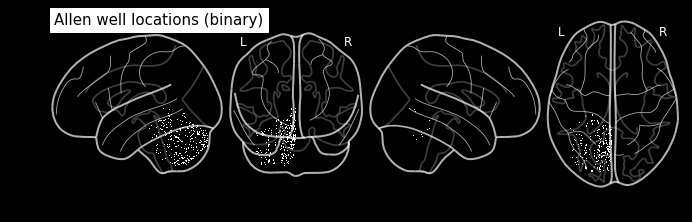

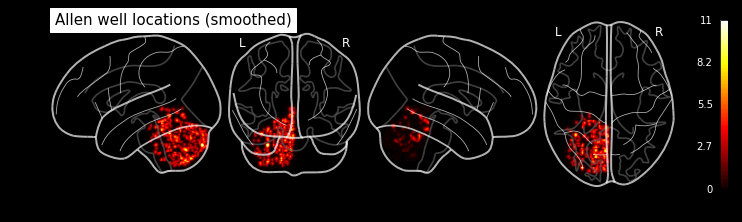

In [303]:
## do the actual plotting of the position of the wells
plotting.plot_glass_brain(out_img,black_bg=True,display_mode='lyrz',title="Allen well locations (binary)")
out_img_s = math_img("img * 100",img = out_img_s)
plotting.plot_glass_brain(out_img_s,black_bg=True,threshold=0.0001,display_mode='lyrz',
                          colorbar=True,title="Allen well locations (smoothed)")